In [1]:
import numpy as np
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

In [2]:
def objfun1(x):
    x1, x2, x3 = x

    with np.errstate(invalid='ignore'):
        result = -(3.5 * (x1 - 2.1 * -x2 + 7)**2 - np.sqrt(x1 * x2 + np.log(x3 + 1)) + np.sin(x3 + np.pi)**2)

    if np.any(np.isnan(result)):
      try:
          result[np.isnan(result)] = -np.inf
      except:
          result = -np.inf

    return -result

# Define bounds for the variables
bounds1 = [(-10, 10), (-10, 10), (-10, 10)]
sig = 10000
bits1 = [int(np.ceil(np.log2((bound[1]-bound[0])*sig))) for bound in bounds1]


In [3]:
def objfun2(x):
    x1, x2, x3 = x

    r1 = (x1 - 0.05)**2 + (x2 - 0.5)**2
    r2 = (x1 - 0.6)**2 + (x2 - 0.1)**2
    r3 = (x3 - 0.08)**2 + (x2 - 0.5)**2
    result = 0.8 * np.exp(-r1 / 0.3**2) + 0.2 * np.exp(-r2 / 0.03**2) + 0.9 * np.exp(-r3 / 0.3**2)
    return -result

# Define bounds for the variables
bounds2 = [(-1, 1), (-1, 1), (-1, 1)]
sig = 10000
bits2 = [int(np.ceil(np.log2((bound[1]-bound[0])*sig))) for bound in bounds2]



In [4]:
def binary_to_float(binary, variable_range, precision):
    binary_str = ''.join(map(str, binary))
    int_value = int(binary_str, 2)
    return variable_range[0] + int_value * (variable_range[1] - variable_range[0]) / (2**precision - 1)

def initialize_population(population_size, chromosome_length):
    population = []
    for _ in range(population_size):
        individual = np.random.randint(2, size=chromosome_length)
        population.append(individual)
    return population

def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, min(len(parent1), len(parent2)))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:
            individual[i] = 1 - individual[i]
    return individual

def genetic_algorithm(objective_function,population_size, generations, mutation_rate, variable_ranges, bits,verbose = True):
    chromosome_length = sum (bits)
    population = initialize_population(population_size, chromosome_length)

    for generation in range(generations):
        decoded_population = [(
            binary_to_float(individual[0:bits[0]], variable_ranges[0], bits[0]),
            binary_to_float(individual[bits[0]:(bits[0]+bits[1])], variable_ranges[1], bits[1]),
            binary_to_float(individual[(bits[0]+bits[1])::], variable_ranges[2], bits[2])
        ) for individual in population]

        fitness_values = [-objective_function(decoded_individual) for decoded_individual in decoded_population]

        parents_indices = np.argsort(fitness_values)[-2:]
        parents = [population[i] for i in parents_indices]

        offspring = []
        for _ in range(population_size - 2):
            parent_indices = np.random.choice(len(parents), size=2, replace=False)
            parent1 = parents[parent_indices[0]]
            parent2 = parents[parent_indices[1]]
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([child1, child2])

        offspring = [mutate(individual, mutation_rate) for individual in offspring]

        population = parents + offspring

        best_index = np.argmax(fitness_values)
        best_individual = population[best_index]
        best_individual_str = ''.join([str(bit) for bit in best_individual])
        best_fitness = fitness_values[best_index]
        best_solution = decoded_population[best_index]
        if verbose:
          print(f"Generation {generation + 1}: Best Fitness = {best_fitness}, Best Individual = {best_individual_str}")

    print(f"\nFinal Result: Best Fitness = {best_fitness}, Best Solution = {best_solution}, Best Individual = {best_individual_str}")
    return best_individual, best_fitness, best_solution



In [5]:
def plotter(objective_function, variable_ranges):
  # Define the ranges for each variable
  x1_range = np.arange(variable_ranges[0][0],variable_ranges[0][1],(variable_ranges[0][1]-variable_ranges[0][0])/100)
  x2_range = np.arange(variable_ranges[1][0],variable_ranges[1][1],(variable_ranges[1][1]-variable_ranges[1][0])/100)
  x3_range = np.arange(variable_ranges[2][0],variable_ranges[2][1],(variable_ranges[2][1]-variable_ranges[2][0])/100)

  # Create a meshgrid for the variables
  X1, X2, X3 = np.meshgrid(x1_range, x2_range, x3_range)

  # Calculate the objective function values
  Z = -objective_function([X1, X2, X3])

  # Reshape the 3D arrays into 2D arrays
  X1 = X1.flatten()
  X2 = X2.flatten()
  Z = Z.flatten()

  # Create a 3D plot of the objective function
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X1, X2, Z, c=Z, cmap='viridis', marker='o')  # Use scatter plot instead

  # Set the labels for the axes
  ax.set_xlabel('x1')
  ax.set_ylabel('x2')
  ax.set_zlabel('Objective Value')

  # Add a colorbar for reference
  cbar = plt.colorbar(ax.scatter(X1, X2, Z, c=Z, cmap='viridis', marker='o'), ax=ax, shrink=0.5, aspect=10)
  cbar.set_label('Objective Value')
  cbar.set_ticks([np.min([n for n in Z if abs(n) < np.inf]), Z.max()])

  # Show the plot
  plt.show()

In [6]:
# Use the Genetic Algorithm for optimization
objective_function = objfun1
variable_ranges = bounds1
bits = bits1
best_individual, best_fitness, best_solution = genetic_algorithm(objective_function = objective_function,population_size=100, generations=500, mutation_rate=0.1, variable_ranges=variable_ranges, bits=bits,verbose = False)



Final Result: Best Fitness = 2.8610427621030654, Best Solution = (-3.7577581701590352, -1.5624678133690395, 9.433133823905273), Best Individual = 010011111110011010011011000000000000111110001011111001


In [7]:
# Use SciPy differential evolution for optimization
result = differential_evolution(func = objfun1, bounds = bounds1)
print("Optimized variables:", result.x)
print("Maximum value of the objective function:", -result.fun)

Optimized variables: [-3.52084795 -1.67659572  9.4331217 ]
Maximum value of the objective function: 2.865781919137493


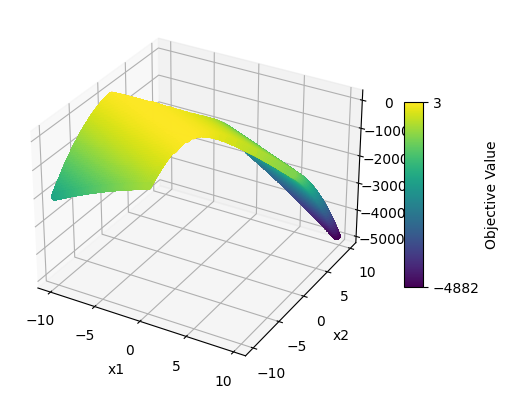

In [8]:
plotter(objective_function = objfun1, variable_ranges = bounds1)

In [ ]:
# Use the Genetic Algorithm for optimization
objective_function = objfun2
variable_ranges = bounds2
bits = bits2
best_individual, best_fitness, best_solution = genetic_algorithm(objective_function = objective_function,population_size=100, generations=1000, mutation_rate=0.1, variable_ranges=variable_ranges, bits=bits, verbose = False)


In [ ]:
# Use SciPy differential evolution for optimization
result = differential_evolution(func = objfun2, bounds= bounds2)
print("Optimized variables:", result.x)
print("Maximum value of the objective function:", -result.fun)

In [ ]:
plotter(objective_function = objfun2, variable_ranges = bounds2)